In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from base64 import b64encode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import HTML, display
from tqdm.notebook import tqdm
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import TimesformerModel, TimesformerConfig
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torchinfo import summary
import copy

2025-06-15 09:48:18.506149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749980898.743856      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749980898.821693      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
features_test = np.load('/kaggle/input/dataset-fp-deepl-4000/features_test.npy')
features_train = np.load('/kaggle/input/dataset-fp-deepl-4000/features_train.npy')
labels_test = np.load('/kaggle/input/dataset-fp-deepl-4000/labels_test.npy')
labels_train = np.load('/kaggle/input/dataset-fp-deepl-4000/labels_train.npy')
test_indices = np.load('/kaggle/input/dataset-fp-deepl-4000/test_indices.npy')
video_files_paths = np.load('/kaggle/input/dataset-fp-deepl-4000/video_files_paths.npy')

In [3]:
print(features_train.shape, features_test.shape)
print(labels_train.shape, labels_test.shape)

(3200, 16, 112, 112, 3) (800, 16, 112, 112, 3)
(3200, 2) (800, 2)


# Making the Dataset and DataLoader Object

In [4]:
class ViolenceDataset(Dataset):
  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    x = self.features[idx]
    x = torch.from_numpy(x).permute(0, 3, 1, 2).float()
    y = torch.tensor(self.labels[idx])
    return x, y

val_ratio = 0.2

train_dataset = ViolenceDataset(features_train, labels_train)
test_dataset = ViolenceDataset(features_test, labels_test)

train_size = int((1 - val_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building the Model

In [5]:
def interpolate_pos_encoding_1d(old_posemb, new_posemb):
    cls_token = old_posemb[:, :1, :]  # (1, 1, C)
    old_tokens = old_posemb[:, 1:, :]  # (1, N_old, C)
    new_tokens = new_posemb[:, 1:, :]  # (1, N_new, C)

    # Interpolate over the sequence (N tokens)
    old_len = old_tokens.shape[1]
    new_len = new_tokens.shape[1]

    # Resize as (1, C, N_old) → interpolate → (1, C, N_new)
    old_tokens = old_tokens.permute(0, 2, 1)
    new_tokens_interp = nn.functional.interpolate(old_tokens, size=new_len, mode='linear', align_corners=False)
    new_tokens_interp = new_tokens_interp.permute(0, 2, 1)

    return torch.cat((cls_token, new_tokens_interp), dim=1)  # (1, N_new+1, C)


class TimeSformer(nn.Module):
  def __init__(self, num_classes=2, freeze_backbone=True):
    super(TimeSformer, self).__init__()
    # Step 1: Create config with your input shape
    config = TimesformerConfig.from_pretrained(
        "facebook/timesformer-base-finetuned-k400",
        num_frames=16,
        image_size=112  # Make sure this matches your input size
    )

    # Step 2: Load model without weights first
    self.backbone = TimesformerModel(config)

    # Step 3: Load pretrained state dict
    pretrained_model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400")
    state_dict = pretrained_model.state_dict()

    # Step 4: Resize positional embeddings if they don't match
    old_posemb = state_dict["embeddings.position_embeddings"]
    new_posemb = self.backbone.embeddings.position_embeddings

    if old_posemb.shape != new_posemb.shape:
        print(f"Resizing position embeddings: {old_posemb.shape} → {new_posemb.shape}")
        new_posemb_resized = interpolate_pos_encoding_1d(old_posemb, new_posemb)
        state_dict["embeddings.position_embeddings"] = new_posemb_resized

    if "embeddings.time_embeddings" in state_dict:
        old_timemb = state_dict["embeddings.time_embeddings"] # (1, 8, 768)
        new_timemb = self.backbone.embeddings.time_embeddings # (1, 16, 768)

        if old_timemb.shape != new_timemb.shape:
            print(f"Resizing time embeddings: {old_timemb.shape} → {new_timemb.shape}")
            old_timemb = old_timemb.permute(0, 2, 1) # (1, 768, 8)
            new_timemb_interp = nn.functional.interpolate(old_timemb, size=new_timemb.shape[1], mode='linear', align_corners=False) # (1, 768, 16)
            new_timemb_interp = new_timemb_interp.permute(0, 2, 1) # (1, 16, 768)

            state_dict["embeddings.time_embeddings"] = new_timemb_interp

    # Load with updated state dict
    self.backbone.load_state_dict(state_dict, strict=False)

    self.classifier = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(self.backbone.config.hidden_size, 256),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(32, num_classes)
    )

    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

  def forward(self, video):
    outputs = self.backbone(video)
    cls_token = outputs.last_hidden_state[:, 0]
    return self.classifier(cls_token)

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_weight = None

    def check_early_stop(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            self.best_weight = copy.deepcopy(model.state_dict())
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                model.load_state_dict(self.best_weight)
                if self.verbose:
                    print(f"Stopping early as no improvement has been observed. With best val_loss at {self.best_loss}")

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSformer(freeze_backbone=True).to(device)

summary(model, input_size=(32, 16, 3, 112, 112))

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Resizing position embeddings: torch.Size([1, 197, 768]) → torch.Size([1, 50, 768])
Resizing time embeddings: torch.Size([1, 8, 768]) → torch.Size([1, 16, 768])


model.safetensors:   0%|          | 0.00/486M [00:00<?, ?B/s]

Layer (type:depth-idx)                                            Output Shape              Param #
TimeSformer                                                       [32, 2]                   --
├─TimesformerModel: 1-1                                           [32, 785, 768]            --
│    └─TimesformerEmbeddings: 2-1                                 [32, 785, 768]            51,456
│    │    └─TimesformerPatchEmbeddings: 3-1                       [512, 49, 768]            (590,592)
│    │    └─Dropout: 3-2                                          [512, 50, 768]            --
│    │    └─Dropout: 3-3                                          [1568, 16, 768]           --
│    └─TimesformerEncoder: 2-2                                    [32, 785, 768]            --
│    │    └─ModuleList: 3-4                                       --                        (120,508,416)
│    └─LayerNorm: 2-3                                             [32, 785, 768]            (1,536)
├─Sequential: 1-2 

# Training Loop

In [8]:
optimizer = optim.SGD(
    model.classifier.parameters(), lr= 0.01
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=5, verbose=True, min_lr=5e-5)

criterion = nn.CrossEntropyLoss()

EPOCH = 50
train_losses = []
val_losses = []
train_accuracies , val_accuracies = [], []
for epoch in range(EPOCH):
    # FASE TRAINING
    model.train()
    total_loss = 0.0
    all_labels, all_preds = [], []
    
    for videos, labels in tqdm(train_loader, desc ="Training Loop"):
        videos, labels = videos.to(device), labels.to(device)
        labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * videos.size(0)
        preds = outputs.argmax(dim=1).detach()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    acc = accuracy_score(all_labels, all_preds)
    train_accuracies.append(acc)

    # FASE EVALUASI
    all_labels, all_preds = [], []
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc="Validation Loop"):
            videos, labels = videos.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1) 

            outputs = model(videos)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * videos.size(0)
            preds = outputs.argmax(dim=1).detach()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss = total_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(acc)

    # Check early stopping condition
    early_stopping.check_early_stop(val_loss, model)
    scheduler.step(val_loss)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f"Epoch {epoch+1}/{EPOCH} - Train loss: {train_loss}, Val loss: {val_loss}")
    print(f"Train accuracy: {train_accuracies[-1]}, Val accuracy: {acc}")

Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/50 - Train loss: 0.6935959354043006, Val loss: 0.6929538369178772
Train accuracy: 0.49609375, Val accuracy: 0.5109375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/50 - Train loss: 0.6930507130920887, Val loss: 0.6927190840244293
Train accuracy: 0.509765625, Val accuracy: 0.553125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/50 - Train loss: 0.6934110194444656, Val loss: 0.6924228101968766
Train accuracy: 0.498046875, Val accuracy: 0.56875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/50 - Train loss: 0.6929323524236679, Val loss: 0.6920850783586502
Train accuracy: 0.506640625, Val accuracy: 0.578125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/50 - Train loss: 0.6923559561371804, Val loss: 0.6915839582681655
Train accuracy: 0.51171875, Val accuracy: 0.60625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/50 - Train loss: 0.6917276732623577, Val loss: 0.6909832060337067
Train accuracy: 0.535546875, Val accuracy: 0.6125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50 - Train loss: 0.6910433106124401, Val loss: 0.6902320653200149
Train accuracy: 0.549609375, Val accuracy: 0.65


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 - Train loss: 0.6902418605983257, Val loss: 0.6892321288585663
Train accuracy: 0.550390625, Val accuracy: 0.6734375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/50 - Train loss: 0.689137963950634, Val loss: 0.6879205375909805
Train accuracy: 0.573828125, Val accuracy: 0.6859375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50 - Train loss: 0.6883572921156883, Val loss: 0.6860355615615845
Train accuracy: 0.57890625, Val accuracy: 0.703125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/50 - Train loss: 0.68540303632617, Val loss: 0.6830538392066956
Train accuracy: 0.6015625, Val accuracy: 0.7078125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50 - Train loss: 0.6843997433781623, Val loss: 0.678754860162735
Train accuracy: 0.6, Val accuracy: 0.696875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/50 - Train loss: 0.6788433350622654, Val loss: 0.6719412297010422
Train accuracy: 0.6265625, Val accuracy: 0.7


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 - Train loss: 0.6724423095583916, Val loss: 0.661448410153389
Train accuracy: 0.6421875, Val accuracy: 0.7140625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50 - Train loss: 0.6607610151171684, Val loss: 0.6445029139518738
Train accuracy: 0.657421875, Val accuracy: 0.709375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 - Train loss: 0.6438209168612957, Val loss: 0.6203010857105256
Train accuracy: 0.6765625, Val accuracy: 0.715625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 - Train loss: 0.6201433800160885, Val loss: 0.59209223985672
Train accuracy: 0.69921875, Val accuracy: 0.7234375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50 - Train loss: 0.5960107840597629, Val loss: 0.558209764957428
Train accuracy: 0.709375, Val accuracy: 0.7265625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 - Train loss: 0.5643766060471535, Val loss: 0.5279104366898537
Train accuracy: 0.72265625, Val accuracy: 0.7359375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 - Train loss: 0.5400282371789217, Val loss: 0.51052655428648
Train accuracy: 0.738671875, Val accuracy: 0.75625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/50 - Train loss: 0.5244951318949461, Val loss: 0.48435706496238706
Train accuracy: 0.752734375, Val accuracy: 0.7671875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50 - Train loss: 0.5134464606642724, Val loss: 0.4665347620844841
Train accuracy: 0.76875, Val accuracy: 0.7765625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 - Train loss: 0.49069207422435285, Val loss: 0.45303010642528535
Train accuracy: 0.78203125, Val accuracy: 0.7890625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50 - Train loss: 0.4667515646666288, Val loss: 0.4323809564113617
Train accuracy: 0.79609375, Val accuracy: 0.790625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 - Train loss: 0.4699040725827217, Val loss: 0.4257297798991203
Train accuracy: 0.794140625, Val accuracy: 0.803125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/50 - Train loss: 0.4576174825429916, Val loss: 0.4144068345427513
Train accuracy: 0.805078125, Val accuracy: 0.8140625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 - Train loss: 0.44409150034189226, Val loss: 0.3970924124121666
Train accuracy: 0.809375, Val accuracy: 0.828125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 - Train loss: 0.428040518052876, Val loss: 0.41993118077516556
Train accuracy: 0.81015625, Val accuracy: 0.8171875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 - Train loss: 0.4207737151533365, Val loss: 0.3811042122542858
Train accuracy: 0.817578125, Val accuracy: 0.8328125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 - Train loss: 0.42302880100905893, Val loss: 0.37196893319487573
Train accuracy: 0.815234375, Val accuracy: 0.8421875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/50 - Train loss: 0.3995024414733052, Val loss: 0.36657912880182264
Train accuracy: 0.82890625, Val accuracy: 0.8375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 - Train loss: 0.41101841237396003, Val loss: 0.36804776415228846
Train accuracy: 0.823046875, Val accuracy: 0.840625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 - Train loss: 0.38551880437880753, Val loss: 0.3528320387005806
Train accuracy: 0.8375, Val accuracy: 0.84375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 - Train loss: 0.3940696334466338, Val loss: 0.34836454689502716
Train accuracy: 0.83203125, Val accuracy: 0.85625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50 - Train loss: 0.3683599937707186, Val loss: 0.3440380714833736
Train accuracy: 0.852734375, Val accuracy: 0.85625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 - Train loss: 0.37272483166307213, Val loss: 0.3271948792040348
Train accuracy: 0.847265625, Val accuracy: 0.865625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 - Train loss: 0.36221314761787654, Val loss: 0.33294014558196067
Train accuracy: 0.85703125, Val accuracy: 0.8640625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 - Train loss: 0.3475786795839667, Val loss: 0.3111151590943336
Train accuracy: 0.862890625, Val accuracy: 0.878125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 - Train loss: 0.34946590233594177, Val loss: 0.3218264639377594
Train accuracy: 0.857421875, Val accuracy: 0.875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 - Train loss: 0.3493471693247557, Val loss: 0.3097194515168667
Train accuracy: 0.854296875, Val accuracy: 0.86875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/50 - Train loss: 0.31912842150777576, Val loss: 0.3054033383727074
Train accuracy: 0.8703125, Val accuracy: 0.8671875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 - Train loss: 0.3164438009262085, Val loss: 0.2983862951397896
Train accuracy: 0.868359375, Val accuracy: 0.8703125


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 - Train loss: 0.3108678311109543, Val loss: 0.2971146531403065
Train accuracy: 0.8734375, Val accuracy: 0.8765625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 - Train loss: 0.3104491079226136, Val loss: 0.3276371702551842
Train accuracy: 0.873828125, Val accuracy: 0.8640625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50 - Train loss: 0.30876409346237776, Val loss: 0.3018630512058735
Train accuracy: 0.872265625, Val accuracy: 0.875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 - Train loss: 0.29946286799386146, Val loss: 0.2877561882138252
Train accuracy: 0.884375, Val accuracy: 0.8796875


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 - Train loss: 0.29137779781594875, Val loss: 0.33618563897907733
Train accuracy: 0.878515625, Val accuracy: 0.85


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 - Train loss: 0.27733673714101315, Val loss: 0.27423655316233636
Train accuracy: 0.885546875, Val accuracy: 0.884375


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50 - Train loss: 0.28152472255751493, Val loss: 0.27714958004653456
Train accuracy: 0.88984375, Val accuracy: 0.8765625


Training Loop:   0%|          | 0/80 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50 - Train loss: 0.2621760138310492, Val loss: 0.2789446573704481
Train accuracy: 0.898828125, Val accuracy: 0.8828125


In [9]:
# Save the model
torch.save(model.state_dict(), 'model_adam.pth')

# # Load the model
# model = TimeSformer()
# model.load_state_dict(torch.load('/content/model.pth'))
# model.to(device)

# Model Evaluation

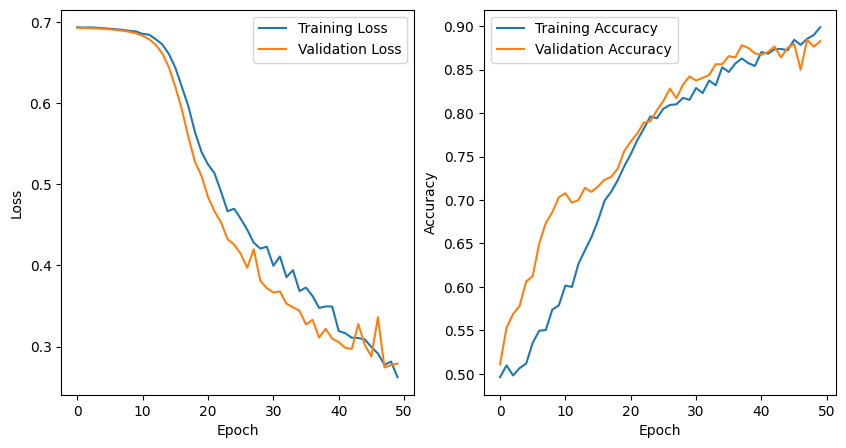

In [10]:
# Plot Losses and Accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predicting the Test Set

In [11]:
# Predict the test dataset
all_labels, all_preds = [], []
model.eval()
total_loss = 0.0
with torch.no_grad():
  for videos, labels in tqdm(test_loader, desc="Test Loop"):
    videos, labels = videos.to(device), labels.to(device)

    outputs = model(videos)
    preds = outputs.argmax(dim=1).detach()
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

all_labels = [np.argmax(label) for label in all_labels]
acc = accuracy_score(all_labels, all_preds)

Test Loop:   0%|          | 0/25 [00:00<?, ?it/s]

In [12]:
print(f"Test set accuracy is {acc}")

Test set accuracy is 0.89


              precision    recall  f1-score   support

           0       0.92      0.85      0.89       403
           1       0.86      0.93      0.89       397

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



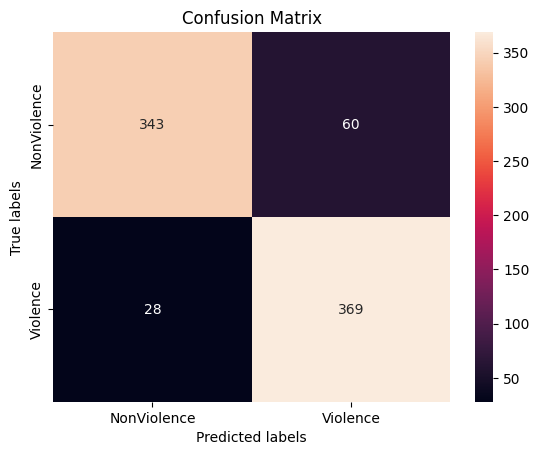

In [13]:
# Show the Classification Report and Confusion Matrix
print(classification_report(all_labels, all_preds))

ax= plt.subplot()
cm=confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NonViolence', 'Violence']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

# Predicting Random Videos From the Test Set

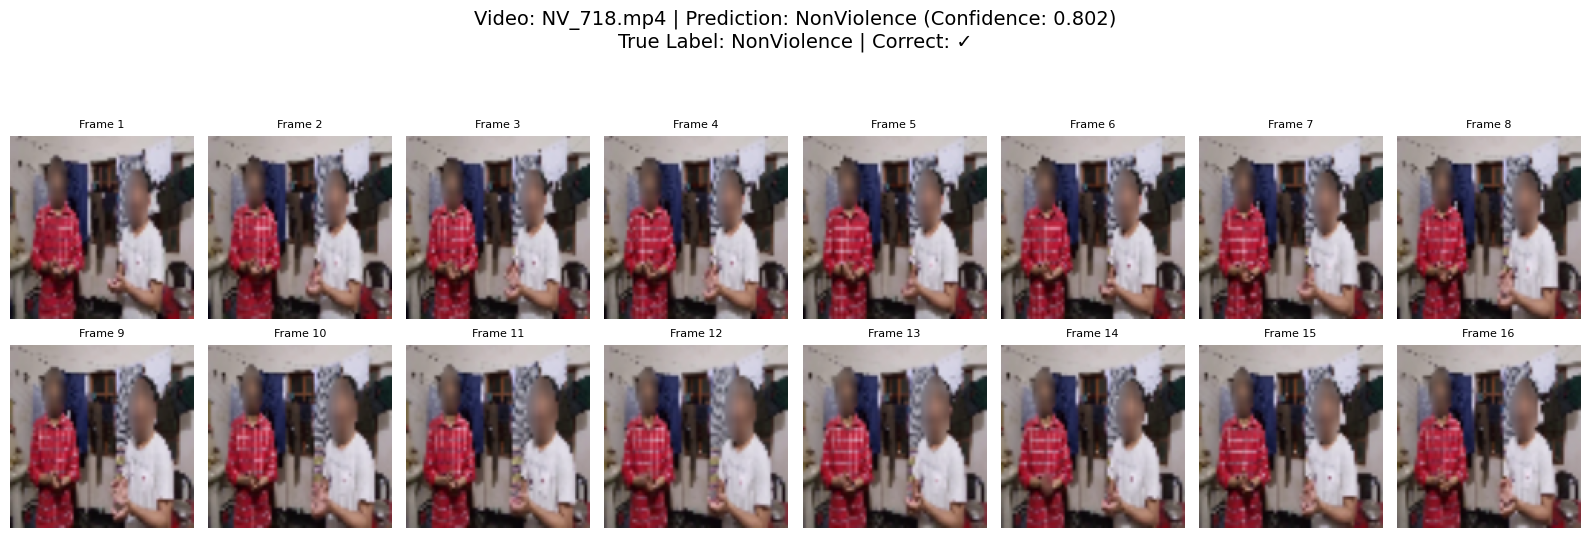

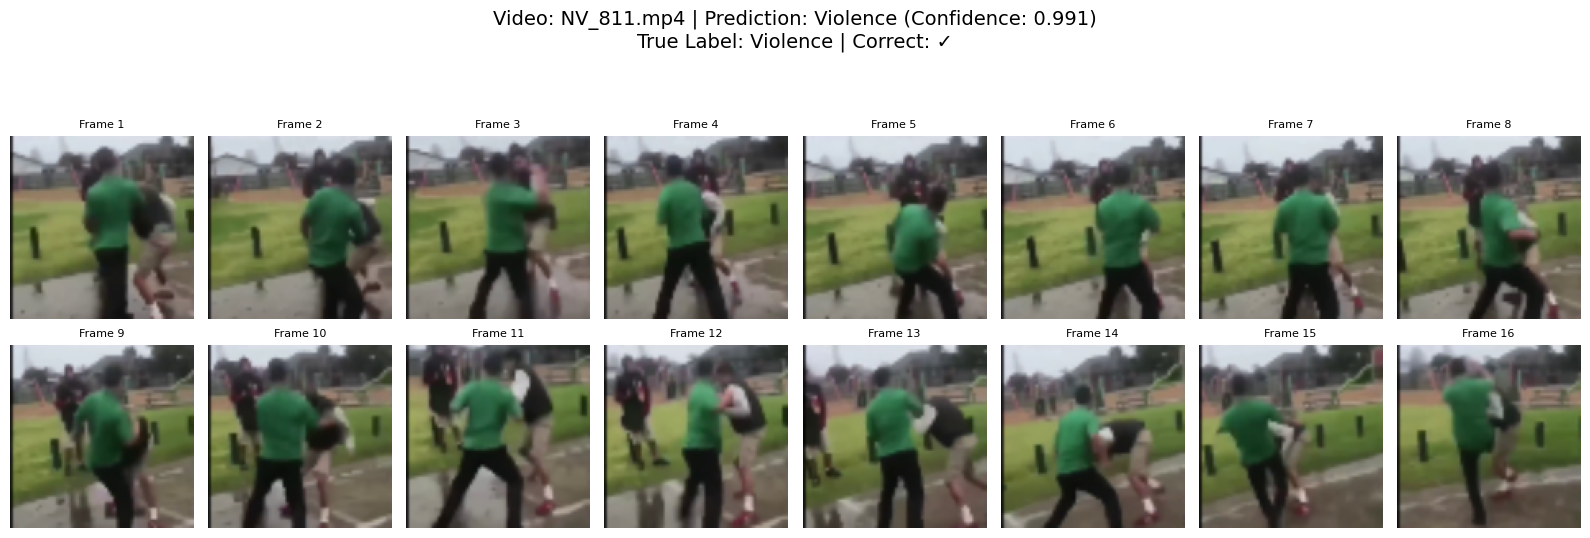

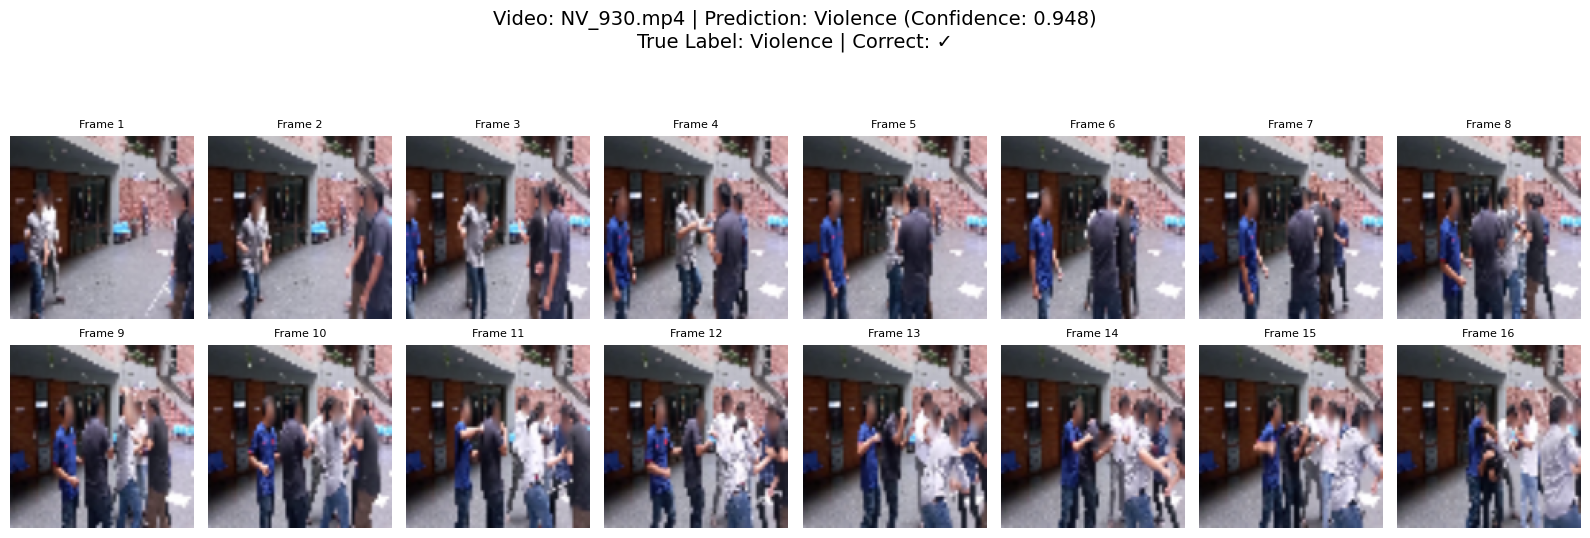

In [14]:
# Choose random indices
num_samples = 3  # or however many you want
indices = random.sample(range(len(features_test)), num_samples)

# Visualization function
def visualize_prediction(video, true_label, pred_label, confidence, video_path):
    plt.figure(figsize=(16, 6))
    plt.suptitle(
        f"Video: {video_path.split('/')[-1]} | "
        f"Prediction: {'Violence' if pred_label==1 else 'NonViolence'} "
        f"(Confidence: {confidence:.3f})\n"
        f"True Label: {'Violence' if true_label==1 else 'NonViolence'} | "
        f"Correct: {'✓' if pred_label == true_label else '✗'}",
        fontsize=14
    )

    for i, frame in enumerate(video):
        frame = frame[..., ::-1]    # fix color
        plt.subplot(2, 8, i+1)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Frame {i+1}", fontsize=8)
        border_color = 'green' if pred_label == true_label else 'red'
        for spine in plt.gca().spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run predictions and visualize
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for idx in indices:
    video = features_test[idx]  # shape: (16, 112, 112, 3)
    true_label = int(np.argmax(labels_test[idx]))
    video_tensor = torch.tensor(video).permute(0, 3, 1, 2).unsqueeze(0).float().to(device)  # (1, 16, 3, 112, 112)

    with torch.no_grad():
      output = model(video_tensor)         # raw logits, shape: (1, 1)
      probs = nn.functional.softmax(output, dim=1)         # shape [1, 2]
      prob_value, pred_label = torch.max(probs, dim=1)  # highest probability and its index

    # Convert to scalar
    pred_label = pred_label.item()      # 0 or 1
    prob_value = prob_value.item()      # confidence (0.0 to 1.0)
    visualize_prediction(video, true_label, pred_label, prob_value, video_files_paths[idx])